In [1]:
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [2]:
yf.pdr_override()
df = pdr.get_data_yahoo("ES=F", start="2016-01-01", end="2023-03-22")
#df = pd.DataFrame(data = df, columns=['Open','High', 'Low','Close','Adj Close','Volume'])
if isinstance(df, pd.DataFrame):
    df.head()

[*********************100%***********************]  1 of 1 completed


In [3]:
df.to_csv("Price_SP500.csv")

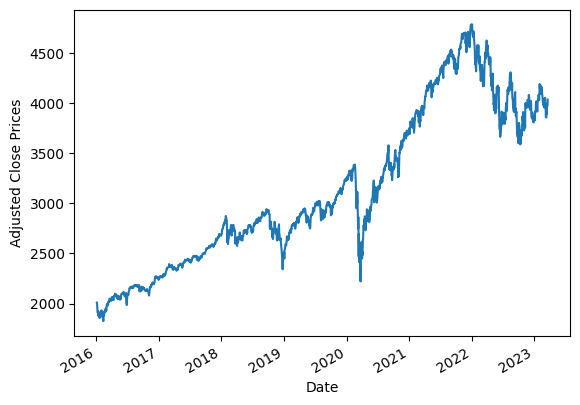

In [4]:
df['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

In [22]:
df.dropna(inplace=True)

In [23]:
x = df.iloc[:, 0:5].values
y = df.iloc[:, 4].values
x.shape
y.shape

(306,)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26,  random_state=0)

In [25]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [26]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 1, 'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 14, 'bootstrap': False}


In [27]:
model = RandomForestRegressor(n_estimators=20, random_state=1, min_samples_split=2, min_samples_leaf=1, max_depth=14, bootstrap=False)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[4185.3125 4557.     4038.3875 3831.3    4214.     4471.     4076.75
 4060.4    4125.025  3886.6125 3956.9    3908.     4160.5    3861.55
 4089.4125 4072.1    4684.75   3981.25   4186.875  4346.5    4595.
 4307.5    4012.25   4485.825  4181.5    3969.475  3720.9375 4033.35
 4631.75   3812.35   3735.2375 3901.075  4520.25   4355.     4591.4
 3792.75   4157.95   4656.5    4027.0875 4307.5    3887.25   4631.75
 3925.     3902.175  4498.     4209.     3992.825  4021.     3857.25
 4656.5    4498.     3882.     3900.25   4336.     3848.3625 4377.675
 4580.75   3829.575  4698.75   4299.25   4188.75   4067.0125 3948.3125
 3910.6125 4524.5    4130.5    4354.075  4028.     4103.375  4038.0375
 3886.6125 4011.65   4157.95   3957.4    4424.5    4166.0875 4548.
 4279.475  4033.55   4067.275 ]
(80,)


In [28]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 3.0206
Mean Squared Error: 18.4723
Root Mean Squared Error: 4.2979
(R^2) Score: 0.9997
Train Score : 100.00% and Test Score : 99.97% using Random Tree Regressor.
Accuracy: 99.93 %.


In [29]:
predictions = pd.DataFrame({"Predictions": predict}, index=pd.date_range(start=df.index[-1], periods=len(predict), freq="D"))
predictions.to_csv("Predicted-price-data.csv")
#colllects future days from predicted values
oneyear_df = pd.DataFrame(predictions[:252])
oneyear_df.to_csv("one-year-predictions.csv")
onemonth_df = pd.DataFrame(predictions[:21])
onemonth_df.to_csv("one-month-predictions.csv")
fivedays_df = pd.DataFrame(predictions[:5])
fivedays_df.to_csv("five-days-predictions.csv")

Buy price and date
   Unnamed: 0  Predictions
3  2023-03-24       3831.3
3    3831.3
Name: Predictions, dtype: float64
Sell price and date
16    4684.75
Name: Predictions, dtype: float64


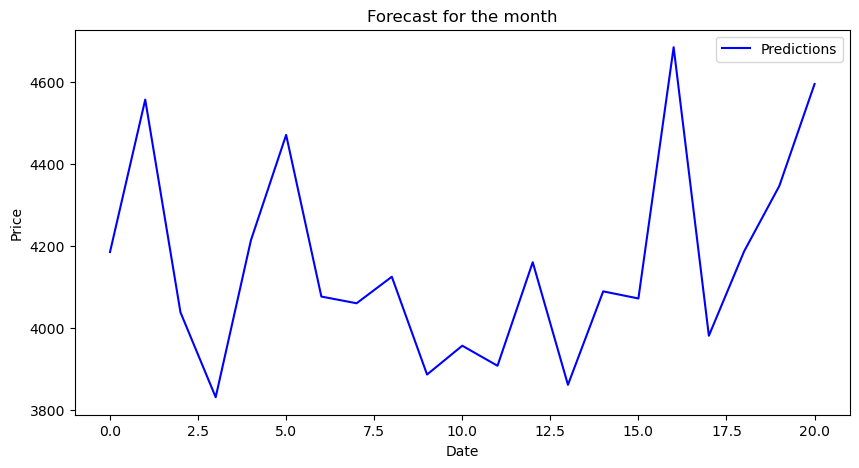

In [30]:
onemonth_df_pred = pd.read_csv("one-month-predictions.csv")
buy_price = min(onemonth_df_pred["Predictions"])
sell_price = max(onemonth_df_pred["Predictions"])
onemonth_buy = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == buy_price]
onemonth_sell = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(onemonth_buy)
print(onemonth_buy.loc[:, 'Predictions'])
print("Sell price and date")
print(onemonth_sell.loc[:, 'Predictions'])
onemonth_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the month", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()